In [1]:
# Practice code from https://github.com/GANs-in-Action/gans-in-action/blob/master/chapter-3/Chapter_3_GAN.ipynb
import matplotlib.pyplot as plt
import numpy as np

# Note: Not sure if tf.keras works since leaky_relu is not a layer in TF
from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential

%matplotlib inline

Using TensorFlow backend.


In [0]:
img_rows = 28
img_cols = 28
channels = 1

# input dimensions
img_shape = (img_rows, img_cols, channels)

# size of the noise vector for the generator
z_dim = 100

# Generator

In [0]:
def build_generator(img_shape, z_dim):
  model = Sequential([Dense(128, input_dim=z_dim),
                     LeakyReLU(alpha=0.01),
                     Dense(28 * 28 * 1, activation='tanh'),
                     Reshape(img_shape)])
  return model

# Discriminator

In [0]:
def build_discriminator(img_shape):
  model = Sequential([Flatten(input_shape=img_shape),
                     Dense(128),
                     LeakyReLU(alpha=0.01),
                     Dense(1, activation='sigmoid')])
  return model

# Building the Model

In [0]:
def build_gan(generator, discriminator):
  model = Sequential([generator, discriminator])
  return model

In [6]:
# Build discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

W0627 02:44:51.822446 140550778394496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0627 02:44:51.843078 140550778394496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0627 02:44:51.856888 140550778394496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0627 02:44:51.888849 140550778394496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0627 02:44:51.913791 140550778394496 deprecation_wrappe

In [0]:
# Build generator
generator = build_generator(img_shape, z_dim)

In [0]:
# Keep discriminator's parameters constant for generator training
discriminator.trainable = False

In [0]:
# Build and compile GAN model with fixed discriminator to train the generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer='adam')

In [0]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
  # Sample random noise
  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
  
  # generate images from random noise
  gen_imgs = generator.predict(z)
  
  # rescale image pixel values to [0, 1]
  gen_imgs = 0.5 * gen_imgs + 0.5
  
  # Set image grid
  fig, axs = plt.subplots(image_grid_rows,
                         image_grid_columns,
                         figsize=(4,4),
                         sharey=True,
                         sharex=True)
  
  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      # output a grid of images
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      cnt += 1

In [0]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
  (X_train, _), (_, _) = mnist.load_data()
  
  # rescale [0, 255] grayscale pixel values to [-1, 1]
  X_train = X_train / 127.5 - 1.0
  
  # Inserts a new axis that will appear at the axis position in the expanded array shape.
  X_train = np.expand_dims(X_train, axis=3)
  
  # Labels for real images: all ones
  real = np.ones((batch_size, 1))
  
  # Labels for fake images: all zeros
  fake = np.zeros((batch_size, 1))
  
  for i in range(iterations):
    # Train the discriminator:
    # Get a random batch of real images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]
    
    # Generate a batch of fake images
    z = np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = generator.predict(z)
    
    # Training discriminator
    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # Train the generator
    # Generate fake images
    z = np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = generator.predict(z)
    
    # Train generator
    g_loss = gan.train_on_batch(z, real)
    
    if (i + 1) % sample_interval == 0:
      # Save losses and accuracies so they can be plotted after training
      losses.append((d_loss, g_loss))
      accuracies.append(100.0 * accuracy)
      iteration_checkpoints.append(i + 1)
      
      # Output training progress
      print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (i + 1, d_loss, 100.0 * accuracy, g_loss))
      
      # output a sample of generated images
      sample_images(generator)

W0627 02:44:52.890832 140550778394496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: 0.076756, acc.: 98.83%] [G loss: 3.848379]
2000 [D loss: 0.057594, acc.: 98.44%] [G loss: 4.274561]
3000 [D loss: 0.102550, acc.: 95.70%] [G loss: 4.940507]
4000 [D loss: 0.132780, acc.: 94.53%] [G loss: 4.637719]
5000 [D loss: 0.303741, acc.: 85.94%] [G loss: 4.394907]
6000 [D loss: 0.218978, acc.: 91.80%] [G loss: 4.454123]
7000 [D loss: 0.279045, acc.: 89.45%] [G loss: 4.340378]
8000 [D loss: 0.301598, acc.: 86.33%] [G loss: 4.126790]
9000 [D loss: 0.349608, acc.: 85.94%] [G loss: 4.026010]
10000 [D loss: 0.318431, acc.: 86.33%] [G loss: 3.365983]
11000 [D loss: 0.199661, acc.: 91.02%] [G loss: 3.329207]
12000 [D loss: 0.281345, acc.: 88.28%] [G loss: 3.787036]
13000 [D loss: 0.400262, acc.: 83.20%] [G loss: 3.209855]
14000 [D loss: 0.322237, acc.: 86.72%] [G loss: 3.013226]
15000 [D loss: 0.406159, acc.: 82.03%] [G loss: 2.890653]
16000 [D loss: 0.357366, acc.: 82.03%] [G loss: 2.965261]
17000 [D loss: 0.410866, acc.: 82.03%] [G loss: 2.664176]
18000 [D loss: 0.402788

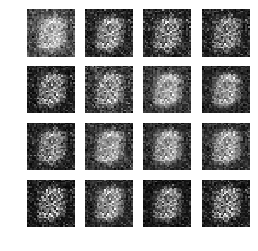

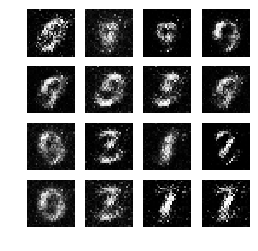

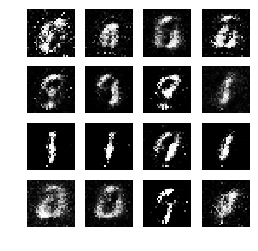

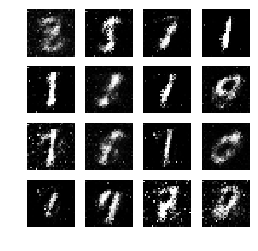

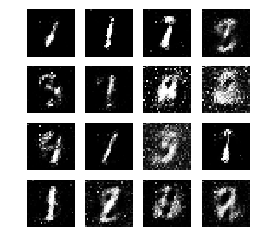

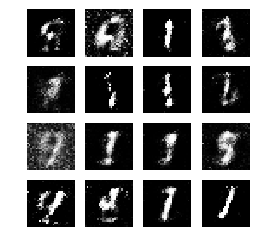

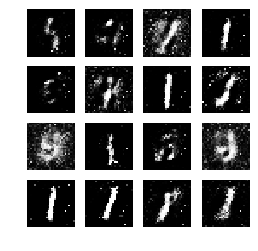

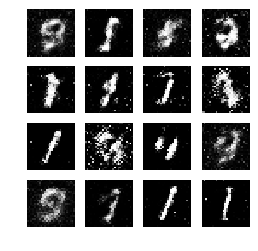

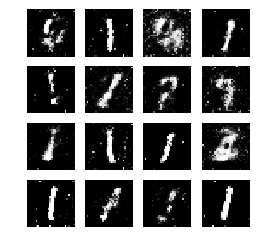

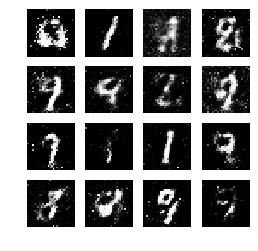

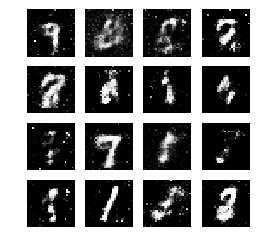

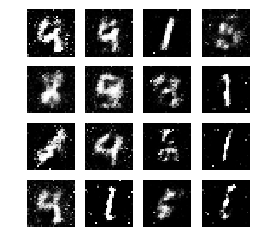

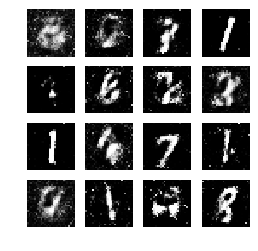

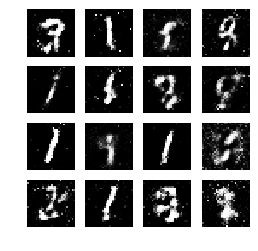

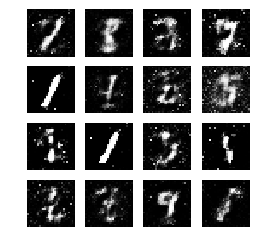

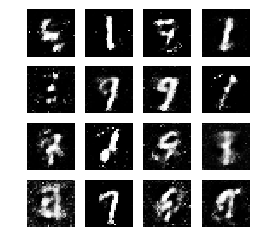

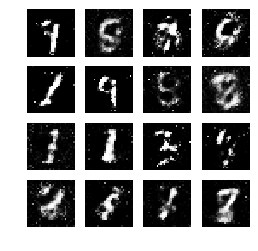

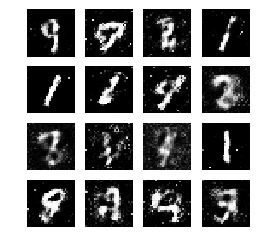

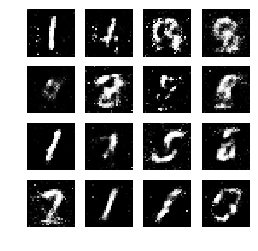

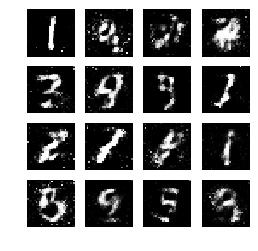

In [12]:
iterations = 20000
batch_size = 128
sample_interval = 1000

# Train GAN and sample
train(iterations, batch_size, sample_interval)